In [1]:
import numpy as np
import xarray as xr 
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import dask.array as da
import time
from numpy import nan
import seaborn as sns
import pandas as pd
import gc
from pathlib import Path
from scipy.interpolate import griddata
#from scipy.interpolate import PchipInterpolator

In [135]:
from dask.distributed import Client
client = Client(scheduler_file = '/*your_path/scheduler.json')
client

<Client: 'tcp://203.247.189.224:41272' processes=16 threads=576, memory=298.02 GiB>

# 2 * sigma based calculation

## Figure 1

In [2]:
# this example point is TLAKE_MON_LUNIT[:,:,1700] 
example_point_ds = xr.open_dataset('/*your_path/TOE_NCs/TLAKE_JAS_surface_samplepoint.nc', cache = False)
glob_mean_trefht = pd.read_csv('/*your_path/TOE_NCs/trefht_glob_mean.csv') 
mpl.font_manager.fontManager.addfont('/home/huanglei/usr/anaconda3/envs/Jun2023/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf')
mpl.font_manager.fontManager.addfont('/home/huanglei/usr/anaconda3/envs/Jun2023/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf')

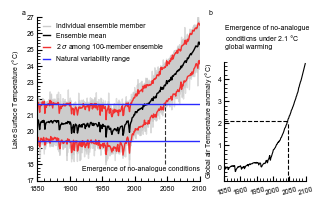

In [141]:
plt.rcParams['font.size'] = 5
cm = 1/2.54
fig = plt.figure(figsize = (8.8 * cm , 5.4 * cm))
gs = mpl.gridspec.GridSpec(2,2, width_ratios=[2,1], height_ratios = [1,4])
ax1 = fig.add_subplot(gs[:2,0])
ax1.plot(example_point_ds.year, example_point_ds.TLAKE.T[:,:99], c= '#cccccc', alpha = 0.7, lw = 1,rasterized=True)
ax1.plot(example_point_ds.year, example_point_ds.TLAKE.T[:,99], c= '#cccccc', lw = 1, label = 'Individual ensemble member')
ax1.plot(example_point_ds.year, example_point_ds.TLAKE.mean('ensemble'), c = 'k', lw = 1, label = 'Ensemble mean')
ax1.plot(example_point_ds.year, example_point_ds.TLAKE.mean('ensemble') + 2 * example_point_ds.TLAKE.std('ensemble'), c = '#f23030', lw = 1)
ax1.plot(example_point_ds.year, example_point_ds.TLAKE.mean('ensemble') - 2 * example_point_ds.TLAKE.std('ensemble'), c = '#f23030', lw = 1, label = "2 $\\sigma$ among 100-member ensemble")
ax1.axhline(example_point_ds.TLAKE.sel(year = slice(1850,1900)).mean() + 2 * example_point_ds.TLAKE.sel(year = slice(1850,1900)).std(), c = '#2a2aff', lw = 1)
ax1.axhline(example_point_ds.TLAKE.sel(year = slice(1850,1900)).mean() - 2 * example_point_ds.TLAKE.sel(year = slice(1850,1900)).std(), c = '#2a2aff', lw = 1, label = 'Natural variability range')
ax1.set_xlim(1850,2100)
ax1.set_xticks(np.arange(1850,2101, 50))
ax1.set_ylim(17,27)
ax1.set_yticks(np.arange(17,27.1,1))
ax1.minorticks_on()
ax1.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 4)
ax1.tick_params(axis = 'y', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 2)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylabel(r'Lake Surface Temperature ($\degree$C)', font = 'Arial')
ax1.legend(frameon = False, handlelength = 1, prop = dict(family = 'Arial'))
ax1.axvline(x = 2047, ymin = 0.1, ymax = 0.47, ls = '--', c = 'k', lw = 0.8, alpha = 0.8)
ax1.text(2100, 17.6, 'Emergence of no-analogue conditions' ,ha ='right', font = 'Arial' )
#--------------------------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[3])
ax2.plot(glob_mean_trefht.year, glob_mean_trefht.Temperature_glob_mean - glob_mean_trefht.Temperature_glob_mean[:50].mean(), c= 'k', lw = 0.8)
ax2.set_ylabel(r'Global air Temperature anomaly ($\degree$C)', font = 'Arial', labelpad = 2.5)
ax2.set_ylim(-0.6,4.8)
ax2.set_yticks(np.arange(0,4.1,))
ax2.minorticks_on()
ax2.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 4, labelrotation = 15)
ax2.tick_params(axis = 'y', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 2)
ax2.set_xlim(1850,2100)
ax2.set_xticks(np.arange(1850,2101, 50))
ax2.spines[['right', 'top']].set_visible(False)
ax2.axvline(x = 2047, ymax = 0.49, ls = '--', c = 'k', lw = 0.8)
ax2.axhline(y = 2.1, xmax = 0.78, ls = '--', c = 'k', lw = 0.8)
ax2.axes.text(1852,5.4,'Emergence of no-analogue\nconditions under 2.1 $\degree$C\nglobal warming', font = 'Arial')
fig.text(0.08,0.89, 'a', font = 'Arial')
fig.text(0.62,0.89, 'b', font = 'Arial')
plt.savefig('/*your_path/Fig_1.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Figure 2

In [92]:
tlake_toe_noanal_sea = xr.open_dataset('/*your_path/TOE_NCs/TLAKE_SEA_TOE_NoAnalogue_backward.nc').TOE_NoAnal

glob_mean_trefht_anom = glob_mean_trefht.Temperature_glob_mean - glob_mean_trefht.Temperature_glob_mean[:50].mean()
lake_therm_region = xr.open_dataset('/*your_path/TOE_NCs/lake_thermal_regions.nc').cluster

In [93]:
# coordinate of lake_therm_region file is different from our results, so convert interpolate its data onto our grid
lat, lon = xr.broadcast(lake_therm_region.lat, lake_therm_region.lon % 360 )
clm_lat, clm_lon = xr.broadcast(tlake_toe_noanal_sea.lat, tlake_toe_noanal_sea.lon)

lake_therm_region_clmgrid = griddata((lat.values.reshape(-1), lon.values.reshape(-1)), lake_therm_region.values.reshape(-1), (clm_lat.values.reshape(-1), clm_lon.values.reshape(-1)), method = 'nearest')

lake_therm_region_clmgrid = xr.DataArray(lake_therm_region_clmgrid.reshape(192,288),
                            dims = ('lat','lon'),
                            coords = tlake_toe_noanal_sea[0,0,...].drop(('depth','season')).coords
                             )


In [94]:
def year_temp_project(x: float):
    if np.isnan(x):
        return np.nan
    elif x > 2099:
        return glob_mean_trefht_anom.max()
    else:
        return glob_mean_trefht_anom.values[glob_mean_trefht.year.values == x][0]
    
def year_temp_project_vect(y):
    a = np.empty(y.shape) * np.nan
    if np.isnan(y).all():
        return a
    else:
        for i in np.arange(y.shape[0]):
            a[i] = year_temp_project(y[i])
        return a

In [95]:
tlake_toe_noanal_tempanom_sea = xr.apply_ufunc(year_temp_project_vect,
               tlake_toe_noanal_sea.chunk(dict(lat = 12,lon = 36, depth = -1)),
               input_core_dims=[['depth']],
               output_core_dims=[['depth']],
               dask = 'parallelized',
               vectorize= True,
               output_dtypes='float'
               ).compute().transpose('depth','season','lat','lon')


In [96]:
tlake_toe_noanal_tempanom = xr.concat((tlake_toe_noanal_tempanom_sea[:,0,:,:].drop('season').sel(lat = slice(-90,-23.5)),
                                  tlake_toe_noanal_tempanom_sea.mean('season').sel(lat = slice(-23.5,23.5)),
                                  tlake_toe_noanal_tempanom_sea[:,2,:,:].drop('season').sel(lat = slice(23.5,90))),
                                 dim='lat')

tlake_toe_noanal_tempanom = xr.where(tlake_toe_noanal_tempanom < 4.5,
         tlake_toe_noanal_tempanom,
         4.5)
tlake_toe_noanal_tempanom = tlake_toe_noanal_tempanom.where(~np.isnan(tlake_toe_noanal_sea[:,0,:,:].drop('season'))) 

In [108]:
zlake = xr.open_dataarray('/*your_path/TOE_NCs/ZLAKE.nc')
# filtering out lakes shallower than= 10 m by lake depth (zlake)
toe_nf = xr.where(lake_therm_region_clmgrid == 4, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_nc = xr.where(lake_therm_region_clmgrid == 5, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_nt = xr.where(lake_therm_region_clmgrid == 9, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_nw = xr.where(lake_therm_region_clmgrid == 1, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_nh = xr.where(lake_therm_region_clmgrid == 2, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_th = xr.where(lake_therm_region_clmgrid == 3, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_sh = xr.where(lake_therm_region_clmgrid == 6, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_sw = xr.where(lake_therm_region_clmgrid == 8, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
toe_st = xr.where(lake_therm_region_clmgrid == 7, tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all') 
mu_toe = np.array([toe_nf[0,...].drop('depth').mean(),
                    toe_nc[0,...].drop('depth').mean(),
                    toe_nt[0,...].drop('depth').mean(),
                    toe_nw[0,...].drop('depth').mean(),
                    toe_nh[0,...].drop('depth').mean(),
                    toe_th[0,...].drop('depth').mean(),
                    toe_sh[0,...].drop('depth').mean(),
                    toe_sw[0,...].drop('depth').mean(),
                    toe_st[0,...].drop('depth').mean()]
                    )
std_toe = np.array([toe_nf[0,...].drop('depth').std(),
                    toe_nc[0,...].drop('depth').std(),
                    toe_nt[0,...].drop('depth').std(),
                    toe_nw[0,...].drop('depth').std(),
                    toe_nh[0,...].drop('depth').std(),
                    toe_th[0,...].drop('depth').std(),
                    toe_sh[0,...].drop('depth').std(),
                    toe_sw[0,...].drop('depth').std(),
                    toe_st[0,...].drop('depth').std()]
                    )

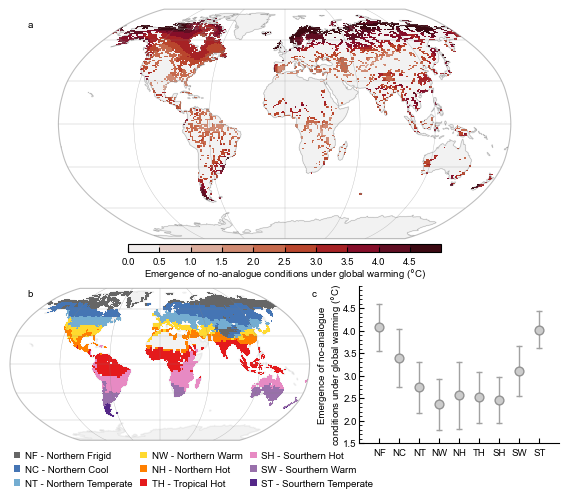

In [109]:
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig = plt.figure(figsize = (18 * cm,15.2 * cm))
gs = mpl.gridspec.GridSpec(2,2, width_ratios=[6,4], height_ratios = [6,4], wspace= 0.2, hspace=0)
#-----------------------------------------------------------------
ax1 = fig.add_subplot(gs[0,:2], projection = ccrs.Robinson())
ax1.coastlines(lw = 0.2, color = 'gray')
ax1.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax1.spines[:].set(color = 'gray', alpha = 0.5)
ax1.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
pl = tlake_toe_noanal_tempanom[0,...].drop('depth').plot(ax = ax1,
                                      levels = np.arange(0,5.01,0.5),
                                      cmap = 'cmo.amp',
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax1,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 40)
cb.ax.set_xticks(np.arange(0,4.6, 0.5))
cb.ax.set_xticklabels(np.arange(0,4.6, 0.5))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Emergence of no-analogue conditions under global warming ($\degree$C)', font = 'Arial', labelpad = 0.03)
#-----------------------------------------------------------------
rgb_value = np.array([
(255,217,47,255),
(255,127,0,255),
(228,26,28,255),
(102,102,102,255),
(69,117,180,255),
(231,138,195,255),
(84,39,136,255),
(153,112,171,255),
(116,173,209,255),
])/255
gs02 = gs[2].subgridspec(7,1)
ax2 = fig.add_subplot(gs02[:6], projection = ccrs.Robinson())
ax2.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax2.spines[:].set(color = 'gray', alpha = 0.5)
ax2.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
lake_therm_region.plot(ax = ax2,
                        transform = ccrs.PlateCarree(),
                       cmap = mpl.colors.ListedColormap(rgb_value),
                       add_colorbar = False,
                       rasterized = True
                       )
#-----------------------------------------------------------------
therml_name = ['NF - Northern Frigid', 
'NC - Northern Cool', 
'NT - Northern Temperate', 
'NW - Northern Warm', 
'NH - Northern Hot', 
'TH - Tropical Hot', 
'SH - Sourthern Hot', 
'SW - Sourthern Warm', 
'ST - Sourthern Temperate']
rgb_value = np.array([
(102,102,102,255),
(69,117,180,255),
(116,173,209,255),
(255,217,47,255),
(255,127,0,255),
(228,26,28,255),
(231,138,195,255),
(153,112,171,255),
(84,39,136,255)
])/255

ax3 = fig.add_subplot(gs02[6])
ax3.set_axis_off()
legend_eles = [mpl.patches.Patch(facecolor = rgb_value[i], label = therml_name[i]) for i in np.arange(9)]
ax3.legend(handles=legend_eles, loc='upper left', ncols = 3, 
           frameon = False, handlelength = 0.65, 
           handletextpad = 0.5, 
           borderaxespad = 0,
           columnspacing = 0.8, 
           prop = dict(family = 'Arial') )
#-----------------------------------------------------------------
gs03 = gs[3].subgridspec(7,1)
ax4 = fig.add_subplot(gs03[:6])
for i in np.arange(9):
    ax4.plot((i+1, i+1), (mu_toe[i] - std_toe[i], mu_toe[i] + std_toe[i]), marker = '_', color = '#a2a2a2', lw = 1, ms = 5)
ax4.scatter(np.arange(1,10), mu_toe, color = '#cccccc',zorder = 20, edgecolor = '#939393', s = 40)
ax4.set_xticks(np.arange(1,10))
ax4.set_xticklabels(['NF', 'NC', 'NT', 'NW', 'NH', 'TH', 'SH', 'SW', 'ST'])
ax4.set_yticks(np.arange(1.5,5,0.5))
ax4.tick_params(axis = 'x', which ='major', direction = 'in', labelfontfamily = 'Arial', pad = 4)
ax4.tick_params(axis = 'x', which ='minor', bottom = False)
ax4.tick_params(axis = 'y', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 2)
ax4.minorticks_on()
ax4.set_ylim(1.5,5)
ax4.set_xlim(0,10)
ax4.spines[['right', 'top']].set_visible(False)
ax4.set_ylabel('Emergence of no-analogue\nconditions under global warming ($\degree$C)', font = 'Arial', labelpad = 0.03)
#-----------------------------------------------------------------
fig.text(0.15,0.85, 'a', font = 'Arial')
fig.text(0.15,0.4, 'b', font = 'Arial')
fig.text(0.55, 0.4, 'c', font = 'Arial')
plt.savefig('/*your_path/Fig_2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Figure 3

In [99]:
tlake_var_sea = xr.open_dataset('/*your_path/TOE_NCs/TLAKE_SEA_ClimatMeanVariability_2000_2100.nc').TLAKE_VARIA
tlake_var_sum = xr.concat((tlake_var_sea[:,0,:,:].drop('season').sel(lat = slice(-90,-23.5)),
                                  tlake_var_sea.mean('season').sel(lat = slice(-23.5,23.5)),
                                  tlake_var_sea[:,2,:,:].drop('season').sel(lat = slice(23.5,90))),
                                 dim='lat')
tlake_var_sum = tlake_var_sum.where(~np.isnan(tlake_toe_noanal_sea[:,0,:,:].drop('season'))) 
tlake_trend_sea = xr.open_dataset('/*your_path/TOE_NCs/TLAKE_SEA_Trend_2000_2100.nc').linear_trend
tlake_trend_sum = xr.concat((tlake_trend_sea[:,0,:,:].drop('season').sel(lat = slice(-90,-23.5)),
                                  tlake_trend_sea.mean('season').sel(lat = slice(-23.5,23.5)),
                                  tlake_trend_sea[:,2,:,:].drop('season').sel(lat = slice(23.5,90))),
                                 dim='lat') * 10 # convert from degree/year to degree/decade by x10
tlake_trend_sum = tlake_trend_sum.where(~np.isnan(tlake_toe_noanal_sea[:,0,:,:].drop('season'))) 

In [110]:
trend_nf = xr.where(lake_therm_region_clmgrid == 4, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_nc = xr.where(lake_therm_region_clmgrid == 5, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_nt = xr.where(lake_therm_region_clmgrid == 9, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_nw = xr.where(lake_therm_region_clmgrid == 1, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_nh = xr.where(lake_therm_region_clmgrid == 2, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_th = xr.where(lake_therm_region_clmgrid == 3, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_sh = xr.where(lake_therm_region_clmgrid == 6, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_sw = xr.where(lake_therm_region_clmgrid == 8, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
trend_st = xr.where(lake_therm_region_clmgrid == 7, tlake_trend_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all') 
mu_trend = np.array([trend_nf[0,...].drop('depth').mean(),
                    trend_nc[0,...].drop('depth').mean(),
                    trend_nt[0,...].drop('depth').mean(),
                    trend_nw[0,...].drop('depth').mean(),
                    trend_nh[0,...].drop('depth').mean(),
                    trend_th[0,...].drop('depth').mean(),
                    trend_sh[0,...].drop('depth').mean(),
                    trend_sw[0,...].drop('depth').mean(),
                    trend_st[0,...].drop('depth').mean()]
                    )
std_trend = np.array([trend_nf[0,...].drop('depth').std(),
                    trend_nc[0,...].drop('depth').std(),
                    trend_nt[0,...].drop('depth').std(),
                    trend_nw[0,...].drop('depth').std(),
                    trend_nh[0,...].drop('depth').std(),
                    trend_th[0,...].drop('depth').std(),
                    trend_sh[0,...].drop('depth').std(),
                    trend_sw[0,...].drop('depth').std(),
                    trend_st[0,...].drop('depth').std()]
                    )

In [111]:
var_nf = xr.where(lake_therm_region_clmgrid == 4, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_nc = xr.where(lake_therm_region_clmgrid == 5, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_nt = xr.where(lake_therm_region_clmgrid == 9, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_nw = xr.where(lake_therm_region_clmgrid == 1, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_nh = xr.where(lake_therm_region_clmgrid == 2, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_th = xr.where(lake_therm_region_clmgrid == 3, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_sh = xr.where(lake_therm_region_clmgrid == 6, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_sw = xr.where(lake_therm_region_clmgrid == 8, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all')
var_st = xr.where(lake_therm_region_clmgrid == 7, tlake_var_sum, np.nan).stack(z = ('lat','lon')).dropna('z', how = 'all') 
mu_var = np.array([var_nf[0,...].drop('depth').mean(),
                    var_nc[0,...].drop('depth').mean(),
                    var_nt[0,...].drop('depth').mean(),
                    var_nw[0,...].drop('depth').mean(),
                    var_nh[0,...].drop('depth').mean(),
                    var_th[0,...].drop('depth').mean(),
                    var_sh[0,...].drop('depth').mean(),
                    var_sw[0,...].drop('depth').mean(),
                    var_st[0,...].drop('depth').mean()]
                    )
std_var = np.array([var_nf[0,...].drop('depth').std(),
                    var_nc[0,...].drop('depth').std(),
                    var_nt[0,...].drop('depth').std(),
                    var_nw[0,...].drop('depth').std(),
                    var_nh[0,...].drop('depth').std(),
                    var_th[0,...].drop('depth').std(),
                    var_sh[0,...].drop('depth').std(),
                    var_sw[0,...].drop('depth').std(),
                    var_st[0,...].drop('depth').std()]
                    )

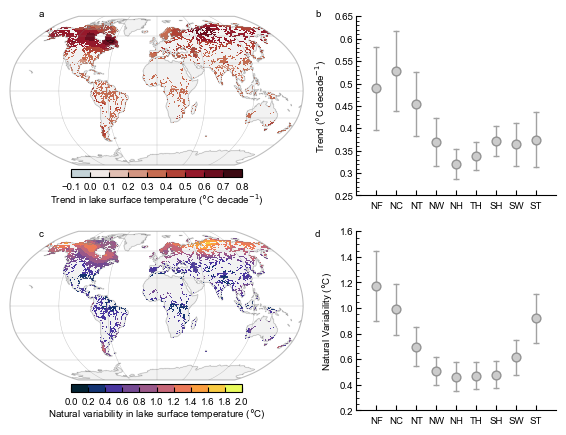

In [112]:
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig = plt.figure(figsize = (18 * cm,13 * cm))
gs = mpl.gridspec.GridSpec(2,2, width_ratios=[6,4])#,wspace= 0.1, hspace=0)
ax1 = fig.add_subplot(gs[0], projection = ccrs.Robinson())
ax1.coastlines(lw = 0.2, color = 'gray')
ax1.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax1.spines[:].set(color = 'gray', alpha = 0.5)
ax1.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
rgb_value = np.array([(196,211,216,255),
(239,232,230,255),
(225,191,179,255),
(211,149,129,255),
(198,108,81,255),
(177,66,54,255),
(149,25,43,255),
(107,13,31,255),
(60,9,18,255)]) / 255
pl = tlake_trend_sum[0,...].drop('depth').plot(ax = ax1,
                                      levels = np.arange(-0.1,0.81,0.1),
                                      cmap = mpl.colors.ListedColormap(rgb_value),
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax1,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 20)
#cb.ax.set_xticks(np.arange(-0.1,0.81,0.1))
#cb.ax.set_xticklabels(np.arange(-0.1,0.81,0.1))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Trend in lake surface temperature ($\degree$C decade$^{-1}$)', font = 'Arial', labelpad = 0.03)
ax2 = fig.add_subplot(gs[2], projection = ccrs.Robinson())
ax2.coastlines(lw = 0.2, color = 'gray')
ax2.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax2.spines[:].set(color = 'gray', alpha = 0.5)
ax2.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
pl = tlake_var_sum[0,...].drop('depth').plot(ax = ax2,
                                      levels = np.arange(0,2.01,0.2),
                                      cmap = 'cmo.thermal',
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax2,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 20)
cb.ax.set_xticks(np.arange(0,2.01,0.2))
#cb.ax.set_xticklabels(np.arange(0,2.01,0.2))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Natural variability in lake surface temperature ($\degree$C)', font = 'Arial', labelpad = 0.03)
ax3 = fig.add_subplot(gs[1])
for i in np.arange(9):
    ax3.plot((i+1, i+1), (mu_trend[i] - std_trend[i], mu_trend[i] + std_trend[i]), marker = '_', color = '#a2a2a2', lw = 1, ms = 5)
ax3.scatter(np.arange(1,10), mu_trend, color = '#cccccc',zorder = 20, edgecolor = '#939393', s = 40)
ax3.set_xticks(np.arange(1,10))
ax3.set_xticklabels(['NF', 'NC', 'NT', 'NW', 'NH', 'TH', 'SH', 'SW', 'ST'])
ax3.set_yticks(np.arange(0.25,0.651,0.05))
ax3.set_yticklabels([0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65])
ax3.tick_params(axis = 'x', which ='major', direction = 'in', labelfontfamily = 'Arial', pad = 4)
ax3.tick_params(axis = 'x', which ='minor', bottom = False)
ax3.tick_params(axis = 'y', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 2)
ax3.minorticks_on()
ax3.set_ylim(0.25,0.65)
ax3.set_xlim(0,10)
ax3.spines[['right', 'top']].set_visible(False)
ax3.set_ylabel('Trend ($\degree$C decade$^{-1}$)', fontfamily = 'Arial')
ax4 = fig.add_subplot(gs[3])
for i in np.arange(9):
    ax4.plot((i+1, i+1), (mu_var[i] - std_var[i], mu_var[i] + std_var[i]), marker = '_', color = '#a2a2a2', lw = 1, ms = 5)
ax4.scatter(np.arange(1,10), mu_var, color = '#cccccc',zorder = 20, edgecolor = '#939393', s = 40)
ax4.set_xticks(np.arange(1,10))
ax4.set_xticklabels(['NF', 'NC', 'NT', 'NW', 'NH', 'TH', 'SH', 'SW', 'ST'])
ax4.set_yticks(np.arange(0.2,1.61,0.2))
#ax4.set_yticklabels([0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65])
ax4.tick_params(axis = 'x', which ='major', direction = 'in', labelfontfamily = 'Arial', pad = 4)
ax4.tick_params(axis = 'x', which ='minor', bottom = False)
ax4.tick_params(axis = 'y', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 2)
ax4.minorticks_on()
ax4.set_ylim(0.2,1.6)
ax4.set_xlim(0,10)
ax4.spines[['right', 'top']].set_visible(False)
ax4.set_ylabel('Natural Variability ($\degree$C)', fontfamily = 'Arial')
fig.text(0.17, 0.88, 'a', font = 'Arial')
fig.text(0.56, 0.88, 'b', font = 'Arial')
fig.text(0.17, 0.45, 'c', font = 'Arial')
fig.text(0.56, 0.45, 'd', font = 'Arial')
plt.savefig('/*your_path/Fig_3.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Figure 4

In [115]:
toe_nf = xr.where(np.logical_and(lake_therm_region_clmgrid == 4, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_nc = xr.where(np.logical_and(lake_therm_region_clmgrid == 5, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_nt = xr.where(np.logical_and(lake_therm_region_clmgrid == 9, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_nw = xr.where(np.logical_and(lake_therm_region_clmgrid == 1, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_nh = xr.where(np.logical_and(lake_therm_region_clmgrid == 2, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_th = xr.where(np.logical_and(lake_therm_region_clmgrid == 3, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_sh = xr.where(np.logical_and(lake_therm_region_clmgrid == 6, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_sw = xr.where(np.logical_and(lake_therm_region_clmgrid == 8, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all')
toe_st = xr.where(np.logical_and(lake_therm_region_clmgrid == 7, zlake <= 10 ), tlake_toe_noanal_tempanom, np.nan).stack(z = ('lat','lon')).dropna('z',how = 'all') 
mu_toe = np.array([toe_nf[:17,...].mean('z'),
                    toe_nc[:17,...].mean('z'),
                    toe_nt[:17,...].mean('z'),
                    toe_nw[:17,...].mean('z'),
                    toe_nh[:17,...].mean('z'),
                    toe_th[:17,...].mean('z'),
                    toe_sh[:17,...].mean('z'),
                    toe_sw[:17,...].mean('z'),
                    toe_st[:17,...].mean('z')]
                    )
std_toe = np.array([toe_nf[:17,...].std('z'),
                    toe_nc[:17,...].std('z'),
                    toe_nt[:17,...].std('z'),
                    toe_nw[:17,...].std('z'),
                    toe_nh[:17,...].std('z'),
                    toe_th[:17,...].std('z'),
                    toe_sh[:17,...].std('z'),
                    toe_sw[:17,...].std('z'),
                    toe_st[:17,...].std('z')]
                    )

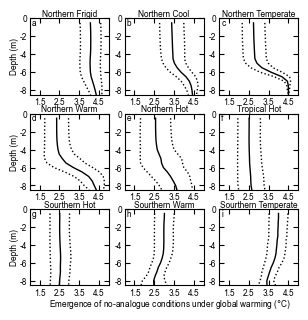

In [116]:
plt.rcParams['font.size'] = 6
cm = 1/2.54
fig, axs = plt.subplots(3,3, figsize = (8.8 * cm, 8.8 * cm))
plt.subplots_adjust(hspace=0.25)
for i in np.arange(9):
    axs[i//3,i % 3].plot(mu_toe[i], -tlake_toe_noanal_tempanom.depth[:17], lw = 1, color = 'k' )
    axs[i//3,i % 3].plot(mu_toe[i] - std_toe[i], -tlake_toe_noanal_tempanom.depth[:17], ls = 'dotted', lw = 1, color = 'k')
    axs[i//3,i % 3].plot(mu_toe[i] + std_toe[i], -tlake_toe_noanal_tempanom.depth[:17], ls = 'dotted', lw = 1, color = 'k')
    axs[i//3,i % 3].set_xlim(1.0,5.0)
    axs[i//3,i % 3].set_xticks([1.5,2.5,3.5,4.5])
    axs[i//3,i % 3].set_xticklabels([1.5,2.5,3.5,4.5], font = 'Arial')
    axs[i//3,i % 3].set_ylim(-8.5,0)
    axs[i//3,i % 3].set_yticks([-8,-6,-4,-2,0])
    axs[i//3,i % 3].set_yticklabels([-8,-6,-4,-2,0], font = 'Arial')
    axs[i//3,i % 3].set_title(therml_name[i][5:], font = 'Arial', pad = 0.7)
    axs[i//3,i % 3].tick_params(right = True, left = True, bottom = True, top = True, axis = 'both', which ='both', direction = 'in', labelfontfamily = 'Arial', pad = 2, width = 0.8)
    axs[i//3,i % 3].text(1.1, -0.8, ['a','b','c','d','e','f','g','h','i'][i], font = 'Arial')
    [ax.set_ylabel('Depth (m)', font = 'Arial', labelpad = 0.5) for ax in axs[[0,1,2], 0]]
fig.text(0.18,0.05, 'Emergence of no-analogue conditions under global warming ($\degree$C)', font = 'Arial')
plt.savefig('/*your_path/Fig_4.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Figure 5

In [85]:
overturn_days_sea = xr.open_dataarray('/*your_path/TOE_NCs/OVERTURN_DAYS_SEASON_climmean_1850_1899.nc')
overturn_perct = xr.concat((100 * overturn_days_sea[0,:,:].drop('season').sel(lat = slice(-90,-23.5) ) / 90,
                                  100 * overturn_days_sea.sum('season').sel(lat = slice(-23.5,23.5)) / 365,
                                  100 * overturn_days_sea[2,:,:].drop('season').sel(lat = slice(23.5,90)) / 90 ),
                                 dim='lat').where(~np.isnan(tlake_toe_noanal_sea[0,0,...].drop(('depth','season'))))
overturn_perct = overturn_perct.where(zlake <= 10)

In [ ]:
def dep_value(x):
    if np.isnan(x).all():
        return np.nan
    else:
        return x[~np.isnan(x)][-1]
toe_bottom = xr.apply_ufunc(dep_value,
                            tlake_toe_noanal_tempanom,
                            input_core_dims=[['depth']],
                            vectorize = True)
trend_bottom = xr.apply_ufunc(dep_value,
                            tlake_trend_sum,
                            input_core_dims=[['depth']],
                            vectorize = True)
var_bottom = xr.apply_ufunc(dep_value,
                            tlake_var_sum,
                            input_core_dims=[['depth']],
                            vectorize = True)


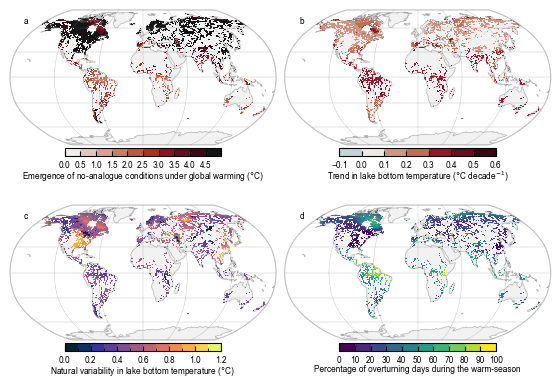

In [86]:
plt.rcParams['font.size'] = 6
cm = 1/2.54
fig, axs = plt.subplots(2,2, figsize = (18 * cm, 11.8 * cm), subplot_kw = {'projection':ccrs.Robinson()})
plt.subplots_adjust(wspace = 0.0)
ax1 = axs[0,0]
ax1.coastlines(lw = 0.2, color = 'gray')
ax1.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax1.spines[:].set(color = 'gray', alpha = 0.5)
ax1.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
pl = toe_bottom.plot(ax = ax1,
                                      levels = np.arange(0,5.01,0.5),
                                      cmap = mpl.colors.ListedColormap(np.concatenate((cmo.cm.amp(np.linspace(0, 1, 9)), np.array([[0.08,0.08,0.08,1]])), axis = 0)),
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax1,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 20)
cb.ax.set_xticks(np.arange(0,4.6, 0.5))
cb.ax.set_xticklabels(np.arange(0,4.6, 0.5))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Emergence of no-analogue conditions under global warming ($\degree$C)', font = 'Arial', labelpad = 0.03)
ax2 = axs[0,1]
ax2.coastlines(lw = 0.2, color = 'gray')
ax2.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax2.spines[:].set(color = 'gray', alpha = 0.5)
ax2.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
rgb_value = np.array([(196,211,216,255),
(239,232,230,255),
(225,191,179,255),
(211,149,129,255),
(198,108,81,255),
(177,66,54,255),
(149,25,43,255),
(107,13,31,255),
(60,9,18,255)]) / 255
pl = trend_bottom.plot(ax = ax2,
                                      levels = np.arange(-0.1,0.61,0.1),
                                      cmap = mpl.colors.ListedColormap(rgb_value),
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax2,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 20)
#cb.ax.set_xticks(np.arange(-0.1,0.81,0.1))
#cb.ax.set_xticklabels(np.arange(-0.1,0.81,0.1))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Trend in lake bottom temperature ($\degree$C decade$^{-1}$)', font = 'Arial', labelpad = 0.03)
ax3 = axs[1,0]
ax3.coastlines(lw = 0.2, color = 'gray')
ax3.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax3.spines[:].set(color = 'gray', alpha = 0.5)
ax3.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
pl = var_bottom.plot(ax = ax3,
                                      levels = np.arange(0,1.21,0.1),
                                      cmap = 'cmo.thermal',
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax3,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 20)
cb.ax.set_xticks(np.arange(0,1.21,0.2))
#cb.ax.set_xticklabels(np.arange(0,2.01,0.2))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Natural variability in lake bottom temperature ($\degree$C)', font = 'Arial', labelpad = 0.03)

ax4 = axs[1,1]
ax4.coastlines(lw = 0.2, color = 'gray')
ax4.add_feature(cf.LAND, color = 'gray', alpha = 0.1)
ax4.spines[:].set(color = 'gray', alpha = 0.5)
ax4.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = False,
              lw = 0.3,
              alpha = 0.5,
              color = 'gray')
pl = overturn_perct.plot(ax = ax4,
                                      levels = np.arange(0,101,10),
                                      cmap = 'viridis',
                                      add_colorbar = False,
                                      transform = ccrs.PlateCarree(),
                                      extend = 'neither',
                                      rasterized = True
                                      )
cb = plt.colorbar(pl,
                  ax = ax4,
                  location = 'bottom',
                  orientation = 'horizontal',
                  pad = 0.02,
                  shrink = 0.57,
                  aspect = 20)
cb.ax.set_xticks(np.arange(0,101,10))
cb.ax.tick_params(axis = 'x', which ='both', direction = 'in', labelfontfamily = 'Arial')
cb.set_label('Percentage of overturning days during the warm-season', font = 'Arial', labelpad = 0.03)
fig.text(0.15, 0.85, 'a', font = 'Arial')
fig.text(0.54, 0.85, 'b', font = 'Arial')
fig.text(0.15, 0.43, 'c', font = 'Arial')
fig.text(0.54, 0.43, 'd', font = 'Arial')
plt.savefig('/*your_path/Fig_5.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()